# Stand-Up Comedy Topic Modeling Across Cultures
## Natural Language Processing (E1282) Research Note, Dr. Sascha Göbel
- Author: Lonny Chen (216697)
- Submission Date: 7 January 2026
- This notebook is part of the GitHub repository at https://github.com/lonnychen/nlp_research_note.

## Summary
TODO from report.
## Contents
1. [Data Collection](#1.-Data-Collection)
2. [Data Preprocessing](#2.-Data-Preprocessing)
3. [Topic Modeling using Latent Dirichlet Allocation (LDiA)](#3.-Topic-Modeling-using-Latent-Dirichlet-Allocation-(LDiA))
4. [Hyperparameter Tuning using Coherence](#4.-Hyperparameter-Tuning-using-Coherence)
5. [Analyze LDiA Model from Best Hyperparameters](#5.-Analyze-LDiA-Model-from-Best-Hyperparameters)
6. [References](#References)

In [1]:
# Local environment
import sys
sys.path.append('../../')
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from data.data_collection import get_channels_shorts_video_ids, get_transcript_from_video_id
from data.data_preprocessing import find_annotations, custom_preprocessor_transcripts, vectorize_transcripts_to_bow
from data.data_preprocessing import custom_tokenizer_spacy0, custom_tokenizer_spacy1, custom_tokenizer_spacy_lemma
from data.data_plotting import plot_transcript_len, create_token_frequency, plot_zipf
from ldia_model.ldia_model import fit_ldia_model, create_df_topic_words_list, get_gensim_coherence_score, tune_hyperparameters_ldia
from ldia_model.ldia_model_plotting import print_topic_words, plot_topic_words, plot_topic_words_4cols, print_dominant_topics, plot_counts_by_group

## 1. Data Collection
### 1.1. Get YouTube video IDs
- Use of [YT-DLP](https://github.com/yt-dlp/yt-dlp) for extracting video information is referenced from [Barriere et al. (2025)](https://github.com/Standup4AI/dataset/) project code.
- **Runtime:** ~12 seconds
- Currently loads CSV snapshot from 3 January 2026

In [5]:
%%time
# Input YouTube channel search information here
channels = [
    {
        'channel': 'Comedy Central Stand-Up',
        'search_url': 'https://www.youtube.com/@standup/shorts',
        'list_search_str': [],
        'language_code': 'en'
    },
    {
        'channel': 'Comedy Central UK',
        'search_url': 'https://www.youtube.com/@comedycentraluk/search?query=standup',
        'list_search_str': [],
        'language_code': 'en'
    }
]
df_channels = get_channels_shorts_video_ids(channels=channels)
#df_channels.to_csv('data/df_channels.csv', index=False)

Channel @standup extracted 404 videos from https://www.youtube.com/@standup/shorts
Channel @comedycentraluk extracted 368 videos from https://www.youtube.com/@comedycentraluk/search?query=standup
CPU times: user 2.54 s, sys: 90.5 ms, total: 2.63 s
Wall time: 10.8 s


/Users/lonnychen/Dropbox/@project - HERTIE SCHOOL/3. NLP (E1282)/A3. Research Note/nlp_research_note/data/data_collection.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat(df_channels_list)


In [6]:
# Load CSV snapshot
df_channels = pd.read_csv('data/df_channels.csv')
df_channels.shape

(768, 8)

### 1.2. Get transcript strings from video IDs
- Use [YouTube Transcript API](https://github.com/jdepoix/youtube-transcript-api) to fetch correct language transcripts.
- Internally uses "Rotating Residential Proxy" from [Webshare](https://www.webshare.io/?referral_code=w0xno53eb50g) to workaround <span style="color:red">IpBlocked</span> exceptions as recommended by [YouTube Transcript API](https://github.com/jdepoix/youtube-transcript-api).
- **Runtime:** ~2 hours for ~770 videos
- Currently loads CSV snapshot from 4 January 2026

In [7]:
%%time
# TEST: one transcript fetch
video_id = 'JYjRBzuVFwQ' #test shorts
get_transcript_from_video_id(video_id, 'en', use_proxy=True)

Fetch completed for video 'JYjRBzuVFwQ'
CPU times: user 128 ms, sys: 31.2 ms, total: 159 ms
Wall time: 5.1 s


"it was great being in a relationship\nwith her but I didn't know like Latino\nwomen like I didn't know that like\nyou're under investigation like it's\njust when you date a Puerto Rican girl\nyou need to have the answers quick you\nneed to like have facts right away\nbecause they will interrogate you and if\nyou don't have the answers quick you\nlook like a liar and they watch men they\nare designed to watch men watching\nwaiting that's what they do they make\nexcellent NFL referees I think if you\nhad Puerto Rican girls reing the games\nyou'd have zero Miss calls the whole\nseason because they see everything so\nthat's just what could you imagine they\nwere the refs they would be right there\nlike um you out of bound stupid no\nno I mean for real you out of\nbounds I don't need instant replay I I\ninstantly saw you step out of bound so\nyou\nknow I mean I don't even know the rules\njust go home\nbye you out the game"

In [8]:
# Read from saved CSV
df_transcripts = pd.read_csv('data/df_channels_transcripts.csv')
df_transcripts.shape

(768, 9)

In [9]:
df_transcripts.head(2)

,video_id,url,title,duration,view_count,channel,channel_id,language_code,transcript
0,JYjRBzuVFwQ,https://www.youtube.com/shorts/JYjRBzuVFwQ,"""If you had Puerto Rican girls reffing the gam...",NaN,192000.0,Comedy Central Stand-Up,@standup,en,it was great being in a relationship\nwith her...
1,Aay2CmDwAoU,https://www.youtube.com/shorts/Aay2CmDwAoU,"""I like professional football."" 🎤: Demetri Mar...",NaN,131000.0,Comedy Central Stand-Up,@standup,en,I like sports I like professional\nfootball I ...


## 2. Data Preprocessing
### 2.0. Video-level cleaning
- Drop duplicate `video_id`s
- TODO: drop BEFORE fetching transcripts

In [10]:
# "Before" counts
df_transcripts['channel_id'].value_counts()

channel_id
@standup            404
@comedycentraluk    364
Name: count, dtype: int64

In [11]:
# Check and drop duplicate video_ids
# Note: video_ids and thus duplicates are unique per-channel (not across channels)
df_transcripts_clean = df_transcripts.drop_duplicates(subset=['video_id'])
df_transcripts_clean['channel_id'].value_counts()

channel_id
@standup            404
@comedycentraluk    313
Name: count, dtype: int64

### 2.1. Transcript-level cleaning
- Check for missing values
- Drop videos with exceptions

In [12]:
# Check missing transcripts
print(f'Count of missing values in transcripts: {df_transcripts_clean['transcript'].isna().sum()}')
# Check caught exception transcripts
exceptions_list = ['TranscriptsDisabled', 'UnexpectedLanguage', 'ReachedListRetryLimit', 'ReachedFetchRetryLimit']
df_transcripts_clean[df_transcripts_clean['transcript'].isin(exceptions_list)][['url', 'transcript']]

Count of missing values in transcripts: 0


,url,transcript
205,https://www.youtube.com/shorts/AxPVZ2qCago,TranscriptsDisabled
380,https://www.youtube.com/shorts/VMsbSWNShzQ,TranscriptsDisabled
389,https://www.youtube.com/shorts/E_duIZZNcpI,UnexpectedLanguage
401,https://www.youtube.com/shorts/2o9jkV-DJ9I,TranscriptsDisabled
415,https://www.youtube.com/watch?v=BEMWzPUVe24,UnexpectedLanguage
578,https://www.youtube.com/watch?v=IDs4TvWEOUE,TranscriptsDisabled


In [13]:
# Drop and "after" counts
df_transcripts_clean2 = df_transcripts_clean[~df_transcripts_clean['transcript'].isin(exceptions_list)]
df_transcripts_clean2['channel_id'].value_counts()

channel_id
@standup            400
@comedycentraluk    311
Name: count, dtype: int64

### 2.2. Tokenization/vectorization
Follow a systematic tokenization/vectorization strategy based on the iterations below. The baseline "iteration 0" case uses the SpaCy [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) English "smart" rules-based [tokenization](https://spacy.io/usage/linguistic-features#tokenization) with no stop words. Scikit-learn [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) creates the "document-term (sparse) matrix", i.e. "Bag of Words".

The custom preprocessor removes transcript annotations (e.g., `[Applause]`) and is the "iteration 0" baseline. Further iterations:
1. Remove "non-words": whitespace, punctuation, digit-only tokens, single characters in the custom tokenizer.
2. Remove list of SpaCy English `STOP_WORDS` (to match SpaCy tokenization, e.g. tokenized contractions)
3. Remove list of conversational stop words (utterances) from manual review 
4. Replace pure text tokens with SpaCy lemmatized tokens

Notes:
- **Runtime:** ~3-5 minutes per-iteration

In [14]:
# Download spaCy tokenizer model (run once)
spacy.cli.download('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 3.9 MB/s  0:00:03 eta 0:00:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [15]:
# Find set of transcript annotations
find_annotations(df_transcripts_clean2['transcript'])

{'[Applause]', '[Laughter]', '[Music]', '[\xa0__\xa0]'}

In [16]:
# TEST custom preprocessor (re)
test_text = "Hello world [Music].\nLet's go to \"N.Y.\", for 'around' - $200!? [Applause]."
custom_preprocessor_transcripts(test_text)

'hello world .\nlet\'s go to "n.y.", for \'around\' - $200!? .'

In [17]:
# TEST custom tokenizer (SpaCy)
custom_tokenizer_spacy1(custom_preprocessor_transcripts(test_text))

['hello', 'world', 'let', "'s", 'go', 'to', 'n.y', 'for', 'around']

#### 2.2.0. Baseline (preprocessor only)

In [18]:
%%time
# Start vocab size collection
vocab_size = []

# Call with spacy0 (no other filtering)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy0
                                                    )
vocab_size.append({'CountVectorizer': 'Baseline (preprocessor only)', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens0.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2min 55s, sys: 5.39 s, total: 3min
Wall time: 3min 2s


#### 2.2.1. Remove non-words (SpaCy Token attributes) in custom tokenizer

In [19]:
%%time
# Call with spacy1 (filter inside tokenizer)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy1
                                                    )
vocab_size.append({'CountVectorizer': 'Remove non-words', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens1.txt', transcripts_bow_tuple[1], fmt='%s')

CPU times: user 2min 55s, sys: 5.18 s, total: 3min
Wall time: 3min 2s


#### 2.2.2. Remove SpaCy `STOP_WORDS`

In [20]:
%%time
# Get and save SpaCy English STOP_WORDS
spacy_en_stop_words = sorted(list(STOP_WORDS))
np.savetxt('data/spacy_en_stop_words.txt', np.array(spacy_en_stop_words), fmt='%s')

# Call with stop_words
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy1,
                                                     stop_words=spacy_en_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Remove SpaCy stop words', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens2.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 19s, sys: 8.34 s, total: 4min 27s
Wall time: 4min 30s


#### 2.2.3. Remove conversational stop words

In [21]:
%%time
# Add to list of stop words
context_stop_words = ['ah', 'aha', 'hmm', 'oh', 'oo', 'ooh', 'uh', 'uhhuh', 'um']
all_stop_words = spacy_en_stop_words + context_stop_words

# Call with additional stop_words
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy1,
                                                     stop_words=all_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Remove conversational stop words', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens3.txt', transcripts_bow_tuple[1], fmt='%s')

CPU times: user 4min 20s, sys: 8.23 s, total: 4min 28s
Wall time: 4min 31s


#### 2.2.4. Use SpaCy lemmatized tokens

In [22]:
%%time
# TEST custom tokenizer/lemmatizer (SpaCy)
test_text = 'She goes to buy apples. He went and bought an apple.'
custom_tokenizer_spacy_lemma(test_text)

# Call using lemmatized tokens
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy_lemma,
                                                     stop_words=all_stop_words
                                                    )
vocab_size.append({'CountVectorizer': 'Use SpaCy lemmatized tokens', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens4.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'll', 'regard', 'use', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 34s, sys: 7.53 s, total: 4min 41s
Wall time: 4min 43s


In [23]:
# Print collected vocabulary sizes
pd.DataFrame(vocab_size)

,CountVectorizer,vocab_size
0,Baseline (preprocessor only),7132
1,Remove non-words,7005
2,Remove SpaCy stop words,6735
3,Remove conversational stop words,6726
4,Use SpaCy lemmatized tokens,5440


### 2.3. Explore "Bag of Words" document-term matrix
Plots and print:
1. Plot per-document transcript length (in tokens) distribution.
2. Print token frequencies: total and document occurrences.
3. Plot per-token rank $r$ vs. frequency $f(r)$ to check Zipf's law (linear-linear and log-log plots) as per [Piantadosi (2014)](https://doi.org/10.3758/s13423-014-0585-6):

$$
f(r) \propto \frac{1}{r^{\alpha}}
$$


The transcript length mean is: 46.78 tokens


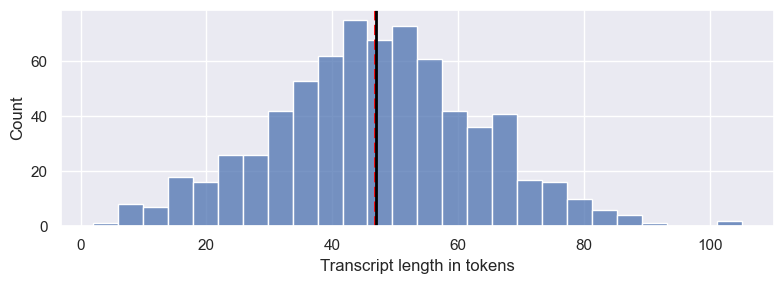

In [28]:
# Plot per-document transcript length (in tokens) distribution
transcript_lengths_array = np.asarray(transcripts_bow_tuple[0].sum(axis=1)).ravel()
print(f'The transcript length mean is: {transcript_lengths_array.mean():.2f} tokens')
plot_transcript_len(pd.Series(transcript_lengths_array))

In [29]:
# Create DF from BoW matrix and feature names
df_token_frequency = create_token_frequency(transcripts_bow_tuple)
df_token_frequency.head(15)

,token,total_frequency,doc_frequency,total_rank,doc_rank
0,like,2050,565,1,1
1,know,954,462,2,2
2,I,701,368,3,3
3,right,447,285,4,4
4,think,343,234,5,5
5,people,327,217,6,6
6,yeah,325,212,7,7
7,come,248,193,10,8
8,want,292,184,8,9
9,thing,222,178,14,10


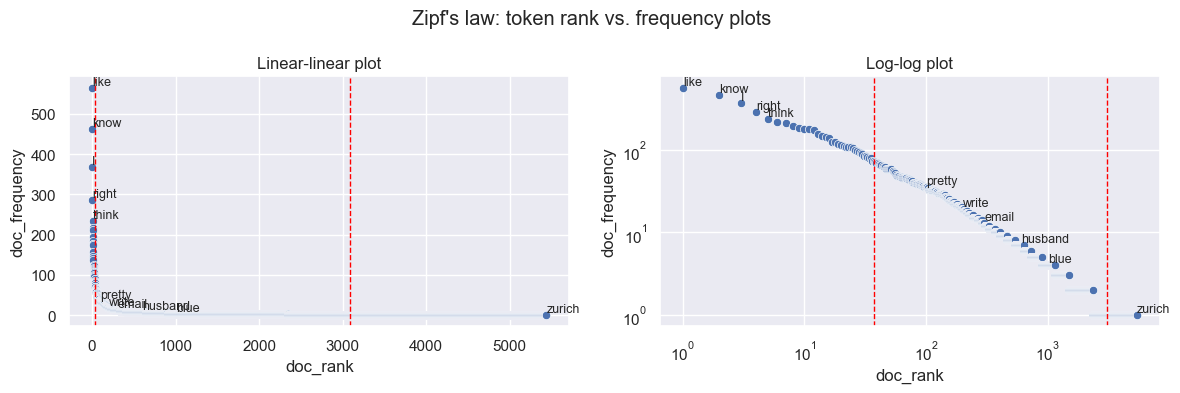

In [43]:
# Plot "Zipf" plots
# min_df_line and min_df_line values from further below so have to hard-code:
# -> the total removed is difference in vocab_size between using lemmatization and using min/max_df = 3128
plot_zipf(df_token_frequency, rank_by='doc',
          top_n=5, bottom_n=1, mid_ranks = [100, 200, 300, 600, 1000],
          min_df_line=3091, max_df_line=37)

### 2.4. Remove very rare (min_df) and very common words (max_df)
Reduce noise for topic modeling by removing very rare and common words:
- Set the `min_df` "cut-off" to a minimum of 2: tokens appearing in only 1 document are removed.
- Set the `max_df` limit to 10%: tokens appearing in more than 10% of documents are removed. **← from LiDA topic-top_words analysis**

In [44]:
%%time
features_dict = {
    'max_features': None, #default: None
    'max_df': 0.1, #default: 1.0 (float)
    'min_df': 2 #default: 1 (int)
}
# Call using features_dict (min_df)
transcripts_bow_tuple = vectorize_transcripts_to_bow(transcripts=df_transcripts_clean2['transcript'],
                                                     custom_preprocessor=custom_preprocessor_transcripts,
                                                     custom_tokenizer=custom_tokenizer_spacy_lemma,
                                                     stop_words=all_stop_words,
                                                     features_dict=features_dict
                                                    )
vocab_size.append({'CountVectorizer': 'Set min_df and max_df', 'vocab_size': len(transcripts_bow_tuple[1])})
np.savetxt('data/tokens_final.txt', transcripts_bow_tuple[1], fmt='%s')

/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/envs/NLP_E1282/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['I', 'far', 'll', 'regard', 'use', 've'] not in stop_words.
  warnings.warn(


CPU times: user 4min 36s, sys: 8.28 s, total: 4min 44s
Wall time: 4min 47s


In [45]:
# Update collected vocabulary sizes
pd.DataFrame(vocab_size)

,CountVectorizer,vocab_size
0,Baseline (preprocessor only),7132
1,Remove non-words,7005
2,Remove SpaCy stop words,6735
3,Remove conversational stop words,6726
4,Use SpaCy lemmatized tokens,5440
5,Set min_df and max_df,2312


The transcript length mean is: 27.47 tokens


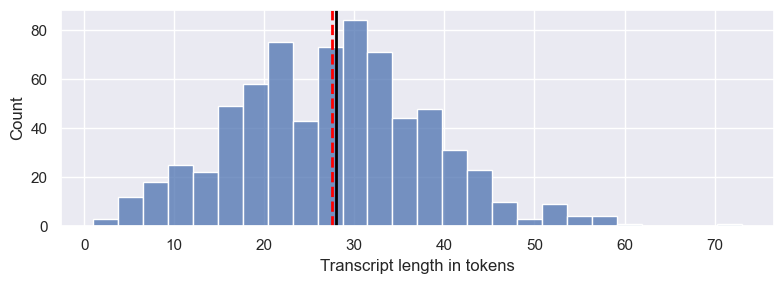

In [46]:
# Plot per-document token length distribution AFTER setting min_df
transcript_lengths_array = np.asarray(transcripts_bow_tuple[0].sum(axis=1)).ravel()
print(f'The transcript length mean is: {transcript_lengths_array.mean():.2f} tokens')
plot_transcript_len(pd.Series(transcript_lengths_array))

In [47]:
# Check BoW matrix size before LDiA
transcripts_bow_tuple[0]

<711x2312 sparse matrix of type '<class 'numpy.int64'>'
	with 15283 stored elements in Compressed Sparse Row format>

## 3. Topic Modeling using Latent Dirichlet Allocation (LDiA)
With a baseline "k" number of topics of 8, fit the scikit-learn [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) (LDiA) model to the tokenized/vectorized transcripts.
- **Runtime:** ~1 second

Analyze the two outputs from fitting LDiA:
1. Topic-words 2D array for interpretation (print and plot per-topic top words)
2. Document-topics 2D array for distribution (dominant topic value counts)

Code referenced from Lab 7 s7-basic-models-ii_challenge.ipynb and Raschka et al. (2022).

In [48]:
%%time
# SET initial number of topics
k_topics=8
# Instantiate and fit LDiA model on document-term BoW using default settings
lda_doc_topics, lda_topic_words = fit_ldia_model(bow_csr=transcripts_bow_tuple[0],
                                                 k_topics=k_topics,
                                                 random_state=123
                                                )
lda_topic_words_norm = lda_topic_words / lda_topic_words.sum(axis=1)[:, None]
lda_doc_topics.shape

CPU times: user 611 ms, sys: 12.1 ms, total: 623 ms
Wall time: 637 ms


(711, 8)

### 3.1. Results Analysis 1: Interpret topics from per-topic list of top words

In [49]:
# Create list of per-topic DataFrames for top words and their scores
n_top_words = 30
df_topic_words_list = create_df_topic_words_list(n_top_words=n_top_words,
                                                 topic_word_scores=lda_topic_words_norm,
                                                 word_names=transcripts_bow_tuple[1]
                                                )
# Print lists of top words for INTERPRETATION of topics
print_topic_words(df_topic_words_list)

Topic 1:
face friend white problem water cat close person game weed brunch high actually new straight french meet hate lose cool football old sport kind favorite black dude boy real ocean 

Topic 2:
mom check walk actually class foot yes touch home big thank white middle comedy buy kid fish yellow box hear old hand hate night end watch sister spell indian cyan 

Topic 3:
gay old date walk watch house new white actually play thank kind change real muslim fine pretty live bless happy bad stop night sexy marry girl understand problem turn kid 

Topic 4:
baby happen ask car bad mom watch black white everybody bit old yes boy die room week sure face home live racist run kid job world big sort great dance 

Topic 5:
party great eat plan bad food friend sex turn fun big run sexy play black break cool date bear girl kid long house sign watch chicken hard free shot susan 

Topic 6:
friend sound white hate new find send walk book turn old stop bill hear night sex word black yes room long brain p

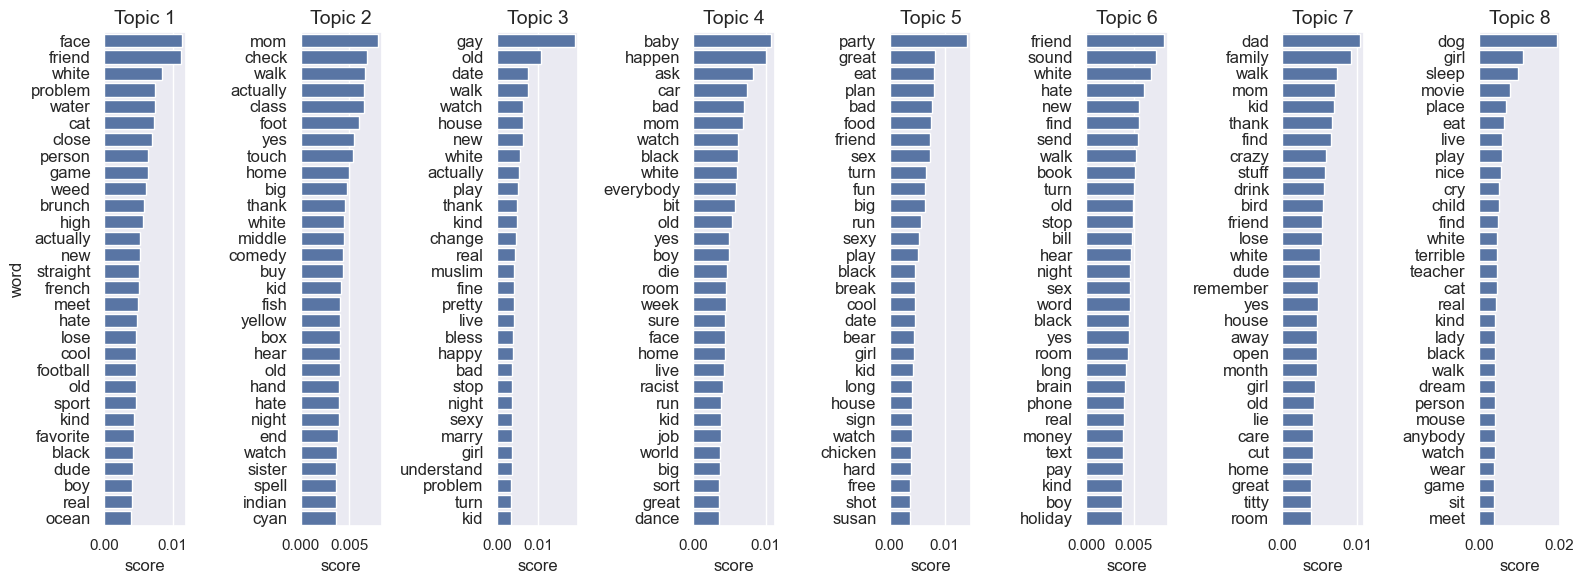

In [53]:
# Plot lists of top words for INTERPRETATION of topics
plot_topic_words(df_topic_words_list)

### 3.2. Results Analysis 2: Check distribution of dominant topics per-document

In [56]:
# Check DISTRIBUTION of dominant topics
df_dominant_topics = print_dominant_topics(lda_doc_topics)

dominant_topic
topic_3           119
topic_4            97
topic_6            95
topic_7            93
topic_5            84
topic_2            83
topic_1            82
topic_8            58
Name: count, dtype: int64


## 4. Hyperparameter Tuning using Coherence
Use gensim [CoherenceModel](https://radimrehurek.com/gensim/models/coherencemodel.html) to calculate **"Cv"** score by default.
- Vary "k" number of topics `n_components`
- TODO: Vary "alpha" `doc_topic_prior` and "beta" `topic_word_prior`
- **Runtimes:**
    - One setting: ~3 minutes
    - All tuning settings: ~20 minutes

Code referenced from [Tsim (2023)](https://stackoverflow.com/a/75248956) on Stack Overflow.

In [57]:
%%time
# TEST: get one coherence score
coherence = get_gensim_coherence_score(df_topic_words_list=df_topic_words_list,
                                       transcripts=df_transcripts_clean2['transcript']
                                      )
print(f'Baseline coherence score is: {coherence:.4f}')

Baseline coherence score is: 0.3371
CPU times: user 3min 13s, sys: 6.37 s, total: 3min 19s
Wall time: 3min 24s


In [58]:
%%time
# Setup hyperparameter space, etc. for tuning
k_space = [3, 5, 8, 10, 12, 15]
n_top_words = 30
random_state = 123

# Call tuning function
df_tuning_results = tune_hyperparameters_ldia(k_space=k_space,
                                              n_top_words=n_top_words,
                                              transcripts=df_transcripts_clean2['transcript'],
                                              transcripts_bow_tuple=transcripts_bow_tuple,
                                              random_state=random_state
                                             )

Tuning with hyperparameter settings: k=3 ...
Completed: k=3 with coherence score of 0.2346
Tuning with hyperparameter settings: k=5 ...
Completed: k=5 with coherence score of 0.2791
Tuning with hyperparameter settings: k=8 ...
Completed: k=8 with coherence score of 0.3371
Tuning with hyperparameter settings: k=10 ...
Completed: k=10 with coherence score of 0.3259
Tuning with hyperparameter settings: k=12 ...
Completed: k=12 with coherence score of 0.3854
Tuning with hyperparameter settings: k=15 ...
Completed: k=15 with coherence score of 0.3727
CPU times: user 19min 24s, sys: 35.4 s, total: 19min 59s
Wall time: 20min 20s


In [59]:
# Look for best hyperparameters
df_tuning_results.sort_values(by='coherence', ascending=False)

,k_topics,coherence
4,12,0.385397
5,15,0.372688
2,8,0.337141
3,10,0.325944
1,5,0.279109
0,3,0.234558


## 5. Analyze LDiA Model from Best Hyperparameters
Best hyperparameters from tuning with a coherence score of 0.39 (low-to-moderate coherence):
- **"k" number of topics = 12**
- TODO: tune alpha, beta

In [60]:
%%time
# Rerun LDiA with best hyperparameters
s_tuning_best = df_tuning_results.sort_values(by='coherence', ascending=False).iloc[0]
k_topics=int(s_tuning_best['k_topics'])
print(f'Refit LDiA with the best hyperparameter settings: k={k_topics}')

# Instantiate and fit LDiA model on document-term BoW using best hyperparameters
lda_doc_topics, lda_topic_words = fit_ldia_model(bow_csr=transcripts_bow_tuple[0],
                                                 k_topics=k_topics,
                                                 random_state=123
                                                )
lda_topic_words_norm = lda_topic_words / lda_topic_words.sum(axis=1)[:, None]

Refit LDiA with the best hyperparameter settings: k=12
CPU times: user 554 ms, sys: 12 ms, total: 566 ms
Wall time: 572 ms


### 5.1. Results Analysis 1: Interpretation
This topic interpretation was assisted by:
1. **Per-topic bar chart plots** which show any dominant leading words by normalized weight.
2. **ChatGPT-5 (2026) prompt** _"Are these 12 topics interpretable?"_ appended with the print output below.
  
These topics were judged to be **moderately interpretable:**
- Topic 8 "dog" > 3%: pets, children's life/play
- Topic 3 "gay" > 2%: gay culture/dating, family, religion
- Topic 12 "black" > 1.5%: black/white friendships, relationships
- Topic 7 "dad" > 1.5% (mom: 1.3%): parenting, family life
- Topic 9 "boy" > 1.5% (girl 0.8%): child/youth dating, social life

All others are considered **uninterpretable** and grouped together to simplify plotting.

In [61]:
# Create list of per-topic DataFrames for top words and their scores
n_top_words = 30
df_topic_words_list = create_df_topic_words_list(n_top_words=n_top_words,
                                                 topic_word_scores=lda_topic_words_norm,
                                                 word_names=transcripts_bow_tuple[1]
                                                )
# Print lists of top words for INTERPRETATION of topics
print_topic_words(df_topic_words_list, txtfile=True)

Topic 1:
face friend cat close wife watch problem game lose lie favorite sexy actually weed person cool sex brunch black stuff kind old foot porn party cause sandwich girl amazing live 

Topic 2:
dude check touch class gay turn anxiety fish spell pay yes hot die old lady actually middle line nice week open brother country phone box true wife gun arrest thank 

Topic 3:
gay thank walk house new play kind white live word turn pretty bless date actually watch hear muslim marry chicken reason mom happy bad wear old sort family understand problem 

Topic 4:
baby room ask sex mom old week happen new bang watch stuff yes date mind naked remember hard sort set lose live girl car bit movie word white kind thank 

Topic 5:
sexy bad food eat bless big sex yes great cool plan free turn susan home clean run school play game girl foreign hard kind watch number drug light movie bear 

Topic 6:
friend white walk send room bill stop sure phone book long ready ginger ant dollar morning sound pay holiday

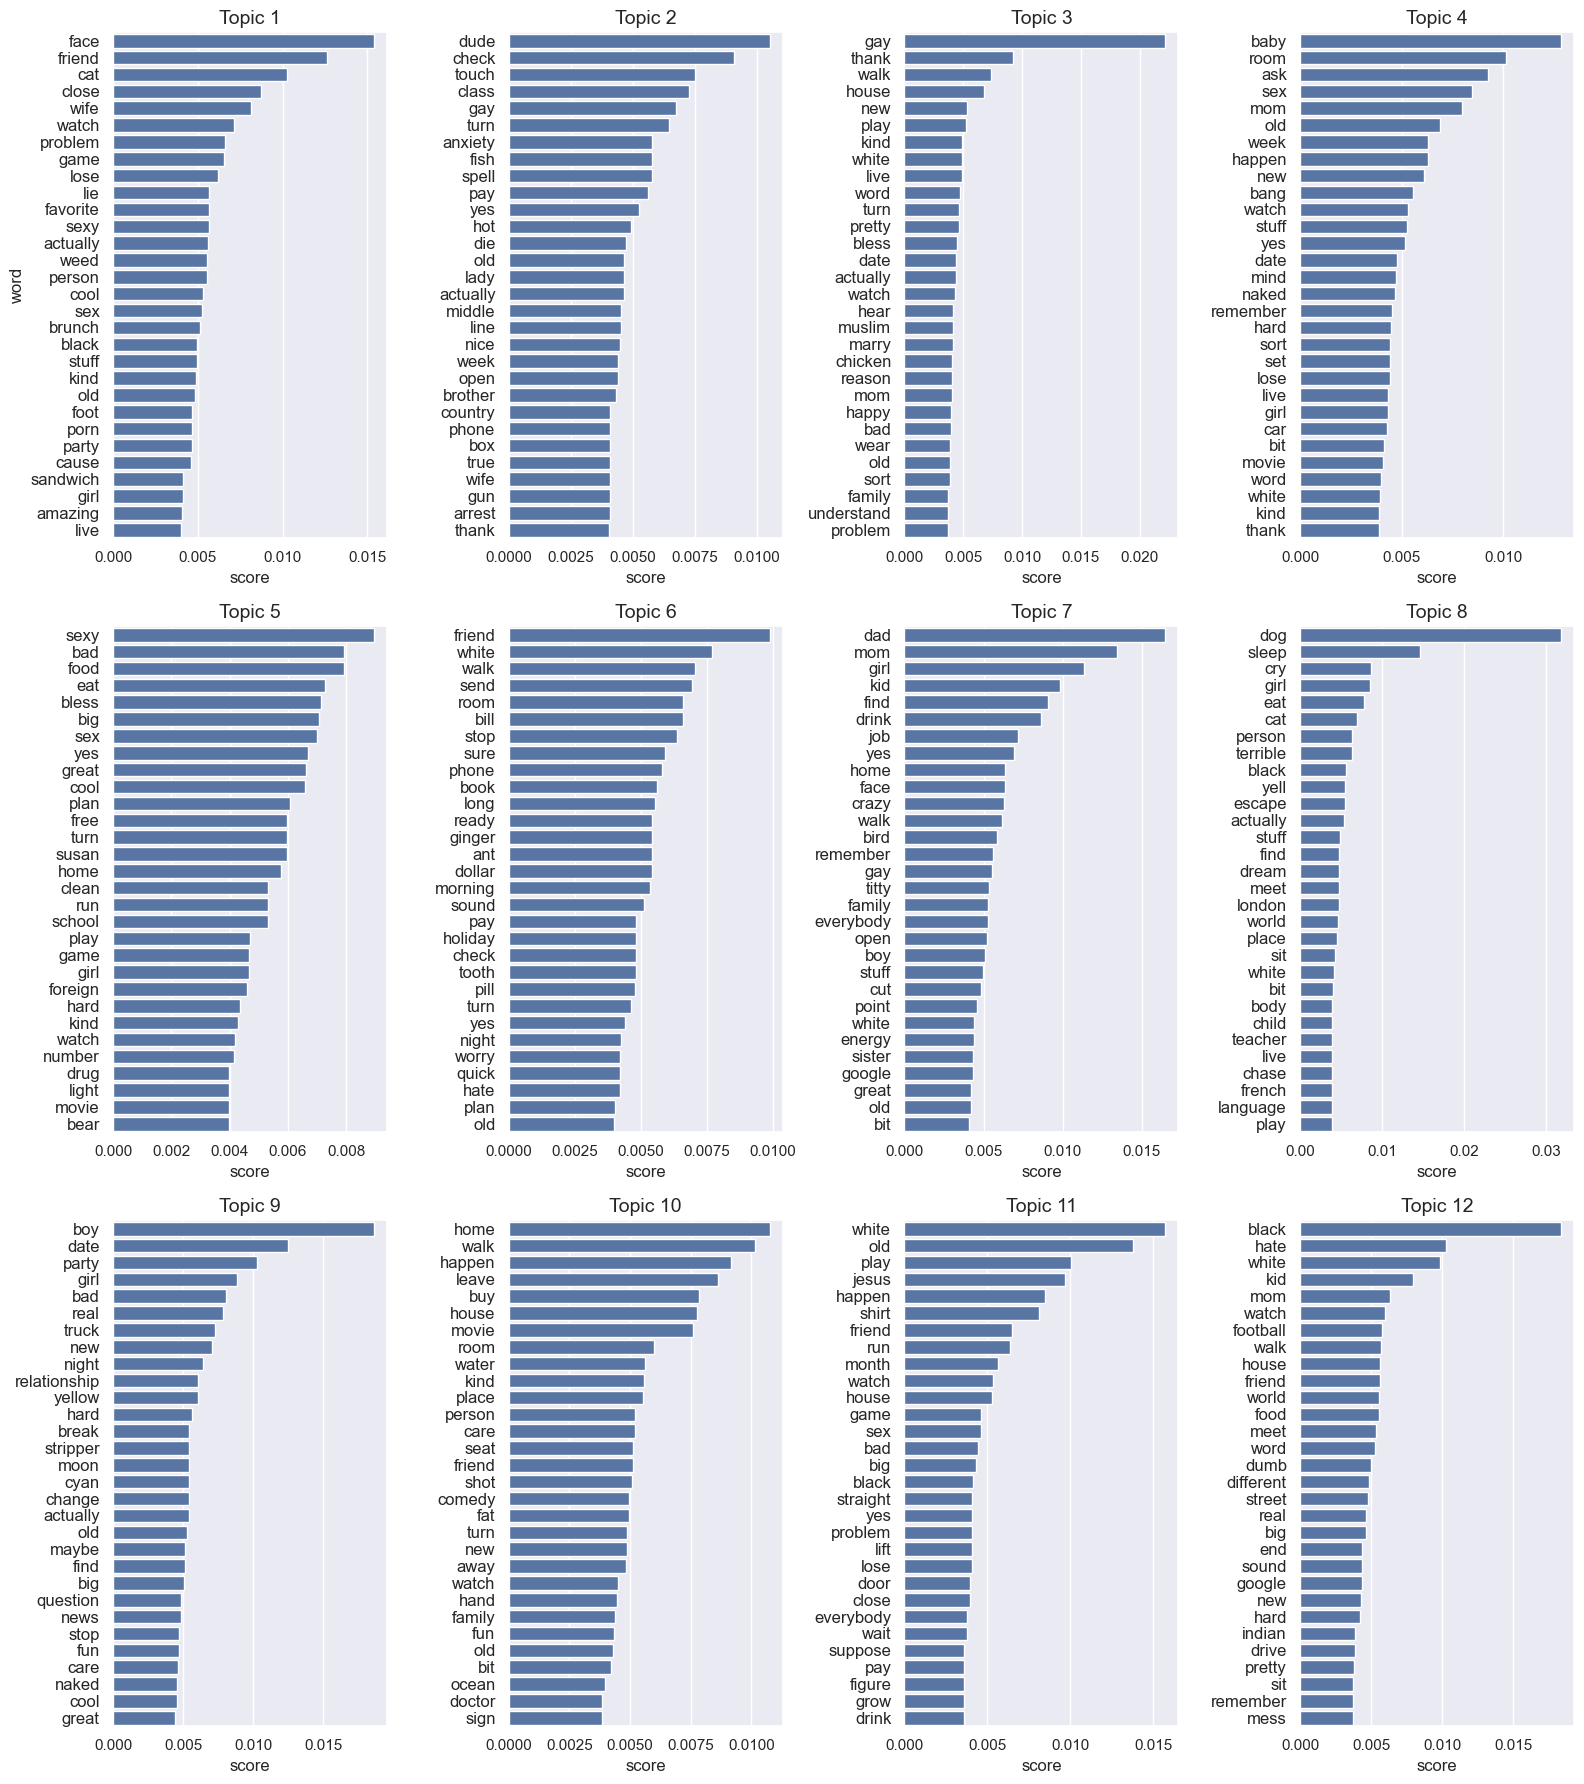

In [62]:
# Plot lists of top words for INTERPRETATION of topics
plot_topic_words_4cols(df_topic_words_list)

### 5.2. Results Analysis 2: Distribution

In [63]:
# Check DISTRIBUTION of dominant topics
df_dominant_topics = print_dominant_topics(lda_doc_topics, txtfile=True)

dominant_topic
topic_3           83
topic_11          69
topic_12          64
topic_7           64
topic_1           62
topic_2           61
topic_4           61
topic_9           56
topic_5           54
topic_6           53
topic_10          47
topic_8           37
Name: count, dtype: int64


In [64]:
# Replace interpretable topics with "top word"
topic_replace_dict = {
    'topic_3': f"'{df_topic_words_list[3-1].loc[0, 'word']}'",
    'topic_7': f"'{df_topic_words_list[7-1].loc[0, 'word']}'",
    'topic_8': f"'{df_topic_words_list[8-1].loc[0, 'word']}'",
    'topic_9': f"'{df_topic_words_list[9-1].loc[0, 'word']}'",
    'topic_12': f"'{df_topic_words_list[12-1].loc[0, 'word']}'",
    'topic_1': 'uninterpretable',
    'topic_2': 'uninterpretable',
    'topic_4': 'uninterpretable',
    'topic_5': 'uninterpretable',
    'topic_6': 'uninterpretable',
    'topic_10': 'uninterpretable',
    'topic_11': 'uninterpretable'
}
df_dominant_topics['dominant_topic'] = df_dominant_topics['dominant_topic'].replace(topic_replace_dict)
df_dominant_topics.value_counts()

dominant_topic 
uninterpretable    407
'gay'               83
'black'             64
'dad'               64
'boy'               56
'dog'               37
Name: count, dtype: int64

### 5.3. Results Analysis 3: Comparison by Comedy Central Channel: UK vs. US (Stand-Up

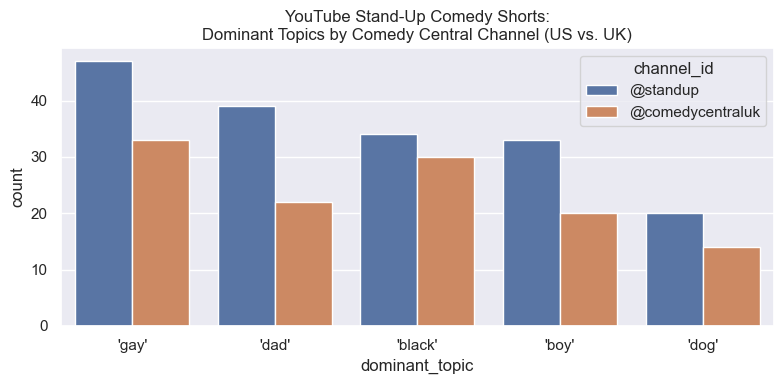

In [65]:
# Add 'dominant_topic' to original transcripts DF
df_transcripts_dtopics = df_transcripts_clean2.copy()
df_transcripts_dtopics['dominant_topic'] = df_dominant_topics['dominant_topic']
df_transcripts_dtopics.to_csv('results/df_transcripts_dominant_topics.csv')

# Drop 'uninterpretable' to simplify plotting
df_plot = df_transcripts_dtopics[df_transcripts_dtopics['dominant_topic']!='uninterpretable']
plot_counts_by_group(df_plot)

### 5.4. Results Analysis 4: Topics Comedy Spot-Check
Through the filtering commands below, I viewed comedy shorts for two topics to "subjectively" **spot-check topicality:**
1. 'gay' dominant topic: https://www.youtube.com/shorts/es8XgMuMBM4 ✅ ON expected topic (gay preferences)
2. 'black' dominant topic: https://www.youtube.com/shorts/6WJ6ID8fvGs ❌ OFF expected topic ("black out")
3. 'dad' dominant topic: https://www.youtube.com/watch?v=Tc5iiXQDbP0 ✅ ON expected topic (dad-son relations)
4. 'boy' dominant topic: https://www.youtube.com/shorts/JCaM_dR0vh0 ✅ ON expected topic (high school party)
5. 'dog'  dominant topic: https://www.youtube.com/watch?v=bRhVcK28dv0 ✅ ON expected topic (dog part interaction)

In [66]:
# Get topics but drop 'uninterpretable' at position 0
topics = df_transcripts_dtopics['dominant_topic'].value_counts().index[1:]

s_video_rows = []
for topic in topics:
    # Try both topic and title
    s_video_row = df_transcripts_dtopics[(df_transcripts_dtopics['dominant_topic']==topic)
        & (df_transcripts_dtopics['title'].str.contains(topic.strip("'"), case=False))]
    # Topic only if not in title
    if s_video_row.empty:
        s_video_row = df_transcripts_dtopics[(df_transcripts_dtopics['dominant_topic']==topic)]
    # Use first
    s_video_rows.append(s_video_row.iloc[0][['dominant_topic', 'title', 'url', 'channel_id']])
pd.concat(s_video_rows, axis=1).T

,dominant_topic,title,url,channel_id
33,'gay',"""Christmas is gay."" 🎤: Matteo Lane #shorts",https://www.youtube.com/shorts/es8XgMuMBM4,@standup
23,'black',"""This year my goal is to black out less.""🎤: Sh...",https://www.youtube.com/shorts/6WJ6ID8fvGs,@standup
545,'dad',Black dads are different kinds of grumpy... 😡,https://www.youtube.com/watch?v=Tc5iiXQDbP0,@comedycentraluk
14,'boy',“SENIORS ‘08” 🎤: Bo Burnham #shorts,https://www.youtube.com/shorts/JCaM_dR0vh0,@standup
404,'dog',Only Dog Owners Will Understand... | Kevin Bri...,https://www.youtube.com/watch?v=bRhVcK28dv0,@comedycentraluk


## References
- Barriere, V., Gomez, N., Hemamou, L., Callejas, S., & Ravenet, B. (2025). *StandUp4AI: A new multilingual dataset for humor detection in stand-up comedy videos.* In C. Christodoulopoulos, T. Chakraborty, C. Rose, & V. Peng (Eds.), Findings of the Association for Computational Linguistics: EMNLP 2025 (pp. 16951–16959). Association for Computational Linguistics. https://doi.org/10.18653/v1/2025.findings-emnlp.919
- Piantadosi, S.T. Zipf’s word frequency law in natural language: A critical review and future directions. *Psychon Bull Rev* 21, 1112–1130 (2014). https://doi.org/10.3758/s13423-014-0585-6
- Raschka, S., Liu, Y. H., & Mirjalili, V. (2022). *Machine learning with PyTorch and Scikit‑Learn*. Packt Publishing.
- Tsim, G. (2023, January 26). Re: How do I calculate the coherence score of an sklearn LDA model? [Online forum post]. Stack Overflow. https://stackoverflow.com/a/75248956
- "Are these 12 topics interpretable?” prompt. *ChatGPT-5*, OpenAI, 2026, Jaunary 7, https://chatgpt.com